# Mixture of Experts(MoE)

In [ ]:
#|default_exp moe

In [ ]:
#|export
import math, torch, torch.nn.functional as F
from torch import nn
from fastai.vision.all import *

In [ ]:
#|hide
import torchvision.transforms as T
import matplotlib as mpl, matplotlib.pyplot as plt
import torch.optim as optim
from fastai.vision.all import *
from torchvision.datasets import MNIST
from FastFF.performance import *

In [ ]:
#|export
def lin(in_dim, out_dim, act=nn.ReLU, bias=True):
    '''Linear layer followed by activation'''
    if act is None: act = nn.Identity
    return nn.Sequential(nn.Linear(in_dim, out_dim, bias), act())

def mlp(in_dim, out_dim, hidden_dim=128, n_hidden=1, act=nn.ReLU, bias=True):
    '''Multilayer perceptron with several hidden layers'''
    if n_hidden==0: return lin(in_dim, out_dim, act, bias)
    res = nn.Sequential(*lin(in_dim, hidden_dim, act, bias))
    for _ in range(n_hidden-1): res+= lin(hidden_dim, hidden_dim, act, bias)
    res += lin(hidden_dim, out_dim, act, bias)
    return res

In [ ]:
#|export
# benchmark comparing nn.ModuleList and nn.Conv1d https://discuss.pytorch.org/t/parallel-execution-of-modules-in-nn-modulelist/43940/11
class Experts(nn.ModuleList):
    """A class representing a collection of experts. Will compute weighted sum of results of topk experts depending on `selected_exps`"""
    
    def forward(self, x, routing_ws, selected_exps):
        mask = F.one_hot(selected_exps, num_classes=len(self)).permute(2, 1, 0)
        for i in range(len(self)):
            idx, top_x = torch.where(mask[i])
            if top_x.shape[0] == 0: continue
            # in torch it is faster to index using lists than torch tensors
            top_x_list = top_x.tolist()
            res = self[i](x[top_x_list]) * routing_ws[top_x_list, idx.tolist(), None]
            if 'out' not in locals(): out = torch.zeros((x.shape[0],*res.shape[1:]), device=x.device)
            out.index_add_(0, top_x, res)
        return out


class MoE(nn.Module):
    '''Mixture of experts network'''
    def __init__(self, in_dim, out_dim, n_experts=4, top_k=4, hidden_dim=128, act=nn.ReLU):
        super().__init__()
        store_attr()
        self.gate = lin(in_dim, n_experts, act=act, bias=False)
        self.experts = Experts(mlp(in_dim,out_dim, hidden_dim, act=act) for _ in range(n_experts))
    
    def forward(self,x):
        logits = self.gate(x)
        routing_weights = F.softmax(logits, dim=1)
        self.distr = routing_weights.detach()
        routing_weights, selected_exps = torch.topk(routing_weights, self.top_k, dim=-1)
        routing_weights /= routing_weights.sum(dim=-1, keepdim=True)
        return self.experts(x, routing_weights, selected_exps)

In [ ]:
#|hide
set_seed(0)
n_cores = num_cpus()

bs = 512 # batch size

In [ ]:
#|hide
mean, std = 0.130652368068695068, 0.307504087686538696

tfm = T.Compose([T.ToTensor(),T.Normalize((mean,), (std,)),
                 T.Lambda(lambda x: x.view(-1,28*28).squeeze())])

train_dataset = MNIST('../data', train=True, download=True,transform=tfm)
test_dataset = MNIST('../data', train=False, download=True,transform=tfm)
dls = DataLoaders(TfmdDL(train_dataset, bs, True),TfmdDL(test_dataset, bs, False))

In [ ]:
#|hide
#|eval: false

n=4
h=64
topk=4

model = MoE(28*28, 10, n, topk, hidden_dim=h)
cbs = [FFFLeavesDistCB('distr'), GetGradCB(['weight'], model.experts[0][0]), ShowGraphCallback()]
learn = Learner(dls, model, loss_func=F.cross_entropy, metrics=accuracy, opt_func = Adam, cbs=cbs)

epoch,train_loss,valid_loss,accuracy,time
0,0.326504,0.221689,0.934100,00:15
1,0.203544,0.192227,0.941200,00:15
2,0.195249,0.249230,0.922500,00:13
3,0.162984,0.154085,0.955500,00:12
4,0.115126,0.122755,0.965300,00:13
5,0.087218,0.116874,0.969600,00:13
6,0.067686,0.120739,0.966800,00:13
7,0.051763,0.101576,0.972900,00:14
8,0.037707,0.085465,0.978400,00:12
9,0.024575,0.092391,0.978500,00:13


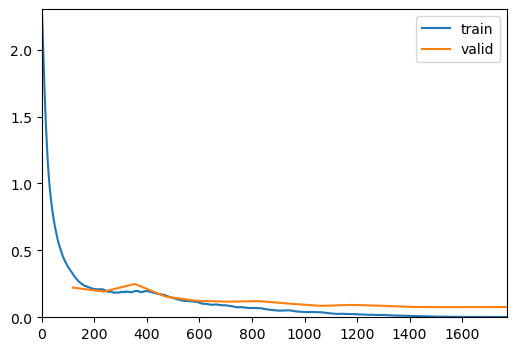

In [ ]:
learn.fit_one_cycle(15, lr_max=2e-2);

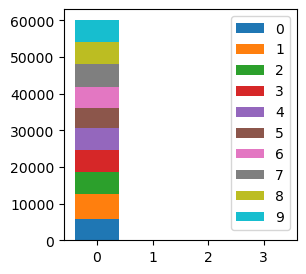

In [ ]:
model.n_leaves = model.n_experts
cbs[0].leaf_hist(-1)

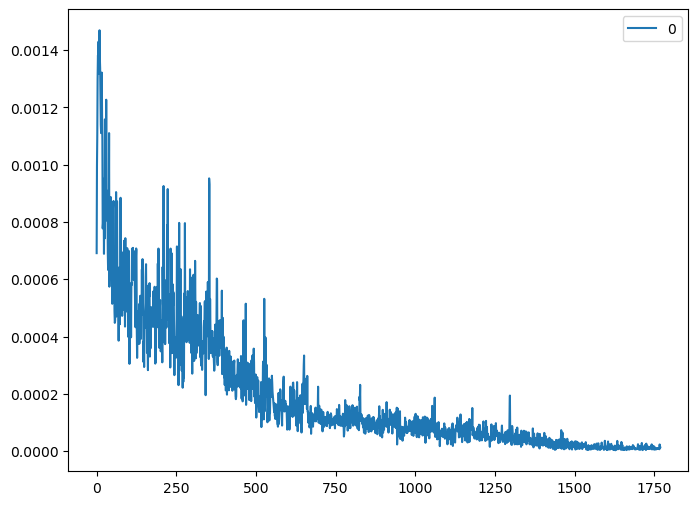

In [ ]:
cbs[1].show('weight', lambda x: x.abs().mean((1,2))[:,None])